In [1]:
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import faiss
import random

In [2]:
'''
class KNN:
    def __init__(self,k):
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            distances = [np.linalg.norm(x - x1) for x1 in self.X_train.values] 
            indices = np.argsort(distances)[:self.k] 
            labels = [self.y_train.iloc[i] for i in indices]
            result = max(set(labels), key = labels.count) 
            predictions.append(result) 
        return predictions
        
class KNN(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sqrt(-2 * np.dot(X, self.X_train.T) + np.sum(self.X_train ** 2, axis=1) + (np.sum(X ** 2, axis=1))[:, np.newaxis])
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        arag = np.argsort(dists)
        for i in range(num_test):
          # A list of length k storing the labels of the k nearest neighbors to
          # the ith test point.
            closest_y = []
            closest_y = (self.y_train[arag[i, : k]])
          #print(closest_y, type(closest_y), len(closest_y))
          
            pass
            count = Counter(closest_y)
            most_frequent = count.most_common(1)
            y_pred[i] = most_frequent[0][0]
            pass

        return y_pred

'''
class KNN(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.le = LabelEncoder()
        y_encoded = self.le.fit_transform(y)
        
        # Normalizacja danych
        X_normalized = self.normalize_data(X)
        
        self.X_train = X_normalized.reshape((X.shape[0], -1)).astype('float32')
        self.y_train = y_encoded
        
        # Tworzenie indeksu FAISS
        d = self.X_train.shape[1]
        self.index = faiss.IndexFlatL2(d)
        self.index.add(self.X_train)

    def predict(self, X, k=1):
        X_flat = X.reshape((X.shape[0], -1)).astype('float32')
        
        # Normalizacja danych testowych
        X_test_normalized = self.normalize_data(X_flat)
        
        # Znalezienie najbliższych sąsiadów za pomocą FAISS
        D, I = self.index.search(X_test_normalized, k)
        
        # Predykcja etykiet
        y_pred_encoded = self.predict_labels(I, k)
        y_pred = self.le.inverse_transform(y_pred_encoded.astype(int))
        return y_pred

    def predict_labels(self, indices, k=1):
        num_test = indices.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = self.y_train[indices[i]]
            count = Counter(closest_y)
            most_frequent = count.most_common(1)
            y_pred[i] = most_frequent[0][0]
        return y_pred
    
    def normalize_data(self, X):
        max_val = np.max(X)
        return X / max_val


In [3]:
# matplotlib figures appear inline in the notebook rather than a new window
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)     # set default size of plots
plt.rcParams["image.interpolation"] = "kaiser"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [4]:
data_dir = "C:/Users/zuzia/Desktop/Coding/Python/semestr IV/Systemy Sztucznej Inteligencji/projekt/archive/images/train"

In [5]:
sub_folders = os.listdir(data_dir)

In [6]:
images = []
labels = []

In [7]:
# Accessing the labels
for sub_folder in sub_folders:
    label = sub_folder

    # Constructing the path to the current sub-folder
    path = os.path.join(data_dir, sub_folder)

    # Listing all images in the current sub-folder
    sub_folder_images = os.listdir(path)

    # Accessing the Images
    for image_name in sub_folder_images:
        # Constructing the path to the current image
        image_path = os.path.join(path, image_name)
        # Loading the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        # Appending the image to the list of images
        images.append(img)
        # Appending the label corresponding to the current sub-folder to the list of labels
        labels.append(label)

In [8]:
# Converting the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
print(len(images))

28821


In [9]:
# Splitting Dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42)

In [10]:
def preprocessing(img):
    img = img / 255.0
    img = cv2.resize(img, (48, 48))
    return img  

In [11]:
X_train = np.array([preprocessing(img) for img in X_train])
X_test = np.array([preprocessing(img) for img in X_test])

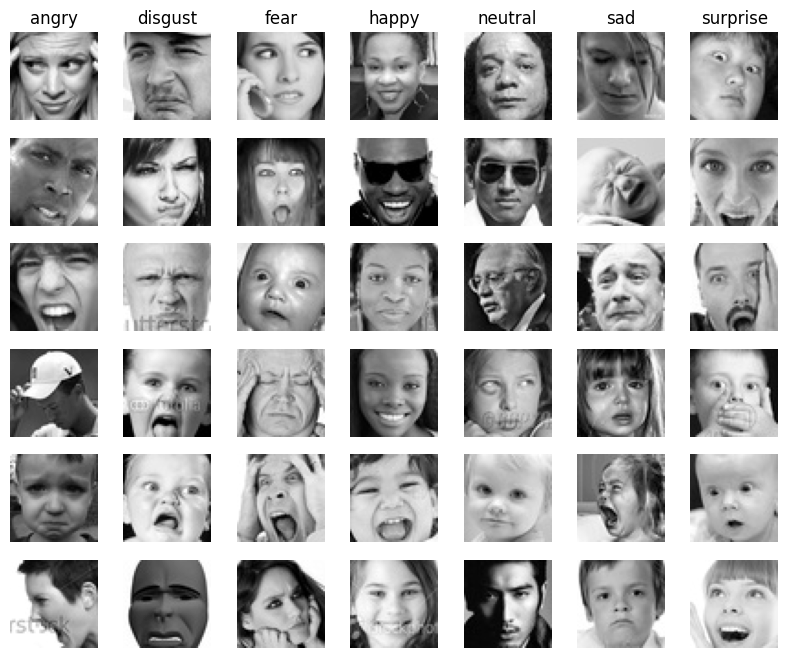

In [12]:
# Visualize some examples from the dataset
# Show a few exapmles of training images from each class
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(classes)
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == cls)
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(np.reshape(X_train[idx], (48, 48)), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(cls)
plt.show()

In [13]:
# instance of kNN for the whole dataset
knn = KNN()
knn.train(X_train, y_train)

In [14]:
y_pred = knn.predict(X_test, k=3)
accuracy = np.mean(y_pred == y_test)
print("Dokładność:", accuracy)

Dokładność: 0.3594102341717259


In [15]:
validation_dir = "C:/Users/zuzia/Desktop/Coding/Python/semestr IV/Systemy Sztucznej Inteligencji/projekt/archive/images/validation"

In [16]:
val_sub_folders = os.listdir(validation_dir)

In [17]:
val_images = []
val_labels = []

In [18]:
for sub_folder in val_sub_folders:
    label = sub_folder
    path = os.path.join(validation_dir, sub_folder)
    sub_folder_images = os.listdir(path)
    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        val_images.append(img)
        val_labels.append(label)

In [19]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [20]:
random.seed(42)

In [21]:
selected_images = []
selected_labels = []

In [22]:
for label in set(val_labels):
    indices = np.where(val_labels == label)[0]
    random_index = random.choice(indices)
    selected_images.append(preprocessing(val_images[random_index]))
    selected_labels.append(label)

In [23]:
selected_images = np.array(selected_images)

In [24]:
predicted_labels = knn.predict(selected_images, k=3)

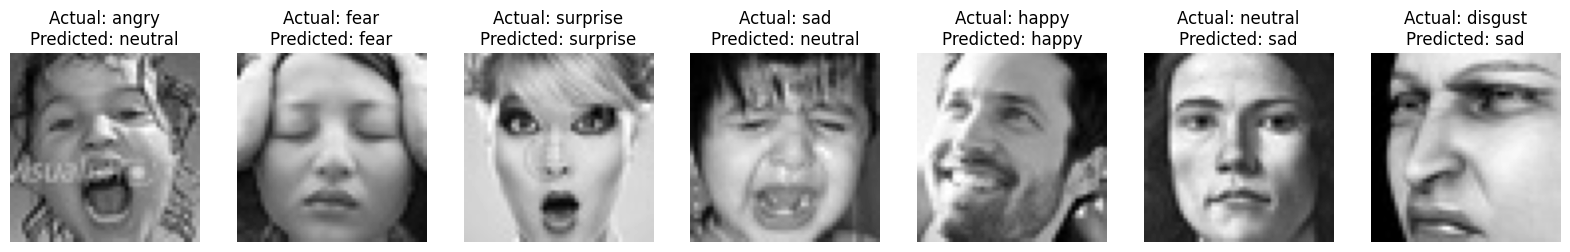

In [25]:
fig, axes = plt.subplots(1, len(selected_images), figsize=(20, 5))
for i, (img, actual, predicted) in enumerate(zip(selected_images, selected_labels, predicted_labels)):
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Actual: {actual}\nPredicted: {predicted}")

plt.show()